In [1]:
from pathlib import Path
import torch
import argparse
import os
import cv2
import numpy as np

from hmr2.configs import CACHE_DIR_4DHUMANS
from hmr2.models import HMR2, download_models, load_hmr2, DEFAULT_CHECKPOINT
from hmr2.utils import recursive_to
from hmr2.datasets.vitdet_dataset import ViTDetDataset, DEFAULT_MEAN, DEFAULT_STD
from utils.rotations import matrix_to_axis_angle

LIGHT_BLUE=(0.65098039,  0.74117647,  0.85882353)

checkpoint = DEFAULT_CHECKPOINT
img_folder = '/workspace/data/smpl_splat/tom/images'
out_folder = 'demo_out'
side_view = False
top_view = False
full_frame = False
save_mesh = False
detector = 'vitdet'
batch_size = 1
file_type = ['*.jpg', '*.png']


# Download and load checkpoints
download_models(CACHE_DIR_4DHUMANS)
model, model_cfg = load_hmr2(checkpoint, init_renderer=False) # Set init_renderer=False inside docker
# otherwise you get some egl opengl c error

# Setup HMR2.0 model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
model.eval()

# Load detector
from hmr2.utils.utils_detectron2 import DefaultPredictor_Lazy
if detector == 'vitdet':
    from detectron2.config import LazyConfig
    import hmr2
    cfg_path = Path(hmr2.__file__).parent/'configs'/'cascade_mask_rcnn_vitdet_h_75ep.py'
    detectron2_cfg = LazyConfig.load(str(cfg_path))
    detectron2_cfg.train.init_checkpoint = "https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/cascade_mask_rcnn_vitdet_h/f328730692/model_final_f05665.pkl"
    for i in range(3):
        detectron2_cfg.model.roi_heads.box_predictors[i].test_score_thresh = 0.25
    detector = DefaultPredictor_Lazy(detectron2_cfg)
elif detector == 'regnety':
    from detectron2 import model_zoo
    from detectron2.config import get_cfg
    detectron2_cfg = model_zoo.get_config('new_baselines/mask_rcnn_regnety_4gf_dds_FPN_400ep_LSJ.py', trained=True)
    detectron2_cfg.model.roi_heads.box_predictor.test_score_thresh = 0.5
    detectron2_cfg.model.roi_heads.box_predictor.test_nms_thresh   = 0.4
    detector       = DefaultPredictor_Lazy(detectron2_cfg)


# Get all demo images that end with .jpg or .png
img_paths = [img for end in file_type for img in Path(img_folder).glob(end)]

smpl_pose = []
smpl_betas = []
vertices = []
key_points_3d = []
key_points_2d = []
# Iterate over all images in folder
for img_path in img_paths:
    img_cv2 = cv2.imread(str(img_path))

    # Detect humans in image
    det_out = detector(img_cv2)

    det_instances = det_out['instances']
    valid_idx = (det_instances.pred_classes==0) & (det_instances.scores > 0.5)
    boxes=det_instances.pred_boxes.tensor[valid_idx].cpu().numpy()

    # Run HMR2.0 on all detected humans
    dataset = ViTDetDataset(model_cfg, img_cv2, boxes)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)

    all_verts = []
    all_cam_t = []
    
    for batch in dataloader:
        batch = recursive_to(batch, device)
        with torch.no_grad():
            out = model(batch)
            global_orient = matrix_to_axis_angle(out['pred_smpl_params']['global_orient'][0, 0])
            body_pose_axis_angles = torch.stack([matrix_to_axis_angle(out['pred_smpl_params']['body_pose'][0, i]) for i in range(23)])
            body_pose = body_pose_axis_angles.view(-1) # shape [69]
            # preappend global_orient to body_pose
            body_pose = torch.cat([global_orient, body_pose]) # shape [72]
            smpl_pose.append(body_pose.cpu().numpy())
            smpl_betas.append(out['pred_smpl_params']['betas'][0].cpu().numpy())
            vertices.append(out['pred_vertices'][0].cpu().numpy())
            key_points_3d.append(out['pred_keypoints_3d'][0].cpu().numpy())
            key_points_2d.append(out['pred_keypoints_2d'][0].cpu().numpy())
            
            

Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../home/user/.cache/4DHumans/logs/train/multiruns/hmr2/0/checkpoints/epoch=35-step=1000000.ckpt`


/home/user/miniconda3/envs/smplpreprocessing/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
model_final_f05665.pkl: 2.77GB [00:23, 116MB/s]                               
/home/user/miniconda3/envs/smplpreprocessing/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1728929558238/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/workspace/4D-Humans/hmr2/utils/geometry.py:61: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim

downsampling_factor=2.3121824264526367
downsampling_factor=2.6050240993499756
downsampling_factor=2.4546866416931152
downsampling_factor=2.5065646171569824
downsampling_factor=2.466994285583496
downsampling_factor=2.582355499267578
downsampling_factor=2.665625810623169
downsampling_factor=2.8065621852874756
downsampling_factor=2.7531497478485107
downsampling_factor=2.618333101272583
downsampling_factor=2.4001991748809814
downsampling_factor=2.754439115524292
downsampling_factor=2.5147526264190674
downsampling_factor=2.2935988903045654
downsampling_factor=2.5776634216308594
downsampling_factor=2.8296561241149902
downsampling_factor=2.550172805786133
downsampling_factor=2.370044708251953
downsampling_factor=2.5053372383117676
downsampling_factor=2.7267801761627197
downsampling_factor=2.3425612449645996
downsampling_factor=2.111093282699585
downsampling_factor=2.816523790359497
downsampling_factor=2.398190498352051
downsampling_factor=2.5109519958496094
downsampling_factor=2.4567589759826

In [105]:
def cam_crop_to_full(cam_bbox, box_center, box_size, img_size, focal_length=5000.):
    # Convert cam_bbox to full image
    img_w, img_h = img_size[:, 0], img_size[:, 1]
    cx, cy, b = box_center[:, 0], box_center[:, 1], box_size
    w_2, h_2 = img_w / 2., img_h / 2.
    bs = b * cam_bbox[:, 0] + 1e-9
    tz = 2 * focal_length / bs
    tx = (2 * (cx - w_2) / bs) + cam_bbox[:, 1]
    ty = (2 * (cy - h_2) / bs) + cam_bbox[:, 2]
    full_cam = torch.stack([tx, ty, tz], dim=-1)
    return full_cam

In [106]:
pred_cam = out['pred_cam']
box_center = batch["box_center"].float()
box_size = batch["box_size"].float()
img_size = batch["img_size"].float()
scaled_focal_length = model_cfg.EXTRA.FOCAL_LENGTH / model_cfg.MODEL.IMAGE_SIZE * img_size.max()
pred_cam_t_full = cam_crop_to_full(pred_cam, box_center, box_size, img_size, scaled_focal_length).detach().cpu().numpy()

In [111]:
img_fn, _ = os.path.splitext(os.path.basename(img_path))
person_id = int(batch['personid'][0])
white_img = (torch.ones_like(batch['img'][0]).cpu() - DEFAULT_MEAN[:,None,None]/255) / (DEFAULT_STD[:,None,None]/255)
input_patch = batch['img'][0].cpu() * (DEFAULT_STD[:,None,None]/255) + (DEFAULT_MEAN[:,None,None]/255)
input_patch = input_patch.permute(1,2,0).numpy()

Rendering

In [143]:
def camera_projection(camera_to_world, K, points):
    camera_to_world = torch.cat([camera_to_world, torch.tensor([[0, 0, 0, 1]])], dim=0) # 4x4

    # Transform points from world to camera space (invert camera-to-world)
    world_to_camera = torch.inverse(camera_to_world)
    
    # check if points need to be homogenized
    if points.shape[-1] == 3:
        points = torch.cat([points, torch.ones_like(points[..., :1])], dim=-1) # Nx4

    # Project points into the camera coordinate space
    p_camera = world_to_camera @ points.transpose(-1, -2)  # 4xN
    
    # Drop the homogeneous coordinate (divide by z)
    p_camera = p_camera[:3, :]  # Get x, y, z
    p_camera[0, :] = -p_camera[0, :]  # Invert x, to match image convention
    p_img = K @ p_camera  # 3xN (still homogeneous)

    # Perspective division (normalize by z)
    p_img[:2, :] /= p_img[2, :]  # Divide u, v by the depth (z)
    
    p_img = p_img[:2, :].transpose(1, 0) # N x 2

    return p_img


def plot_image_with_points(image, p_img, point_size=1):
    # Create a blank image of the camera's width and height
    # Create a blank image (all zeros = black)
    height = image.shape[0]
    width = image.shape[1]

    # Convert projected points to numpy and round them
    pixels_np = p_img.detach().cpu().numpy().round().astype(int)
    
    # convert image from float tensor to uint8
    image = (image * 255).byte().cpu().numpy()

    # Plot each point
    for x, y in pixels_np:
        if 0 <= x < width and 0 <= y < height:
            # Plot point size (a square block)
            image[max(0, y-point_size):min(height, y+point_size), 
                  max(0, x-point_size):min(width, x+point_size)] = [255, 0, 0]  # Red

    return image

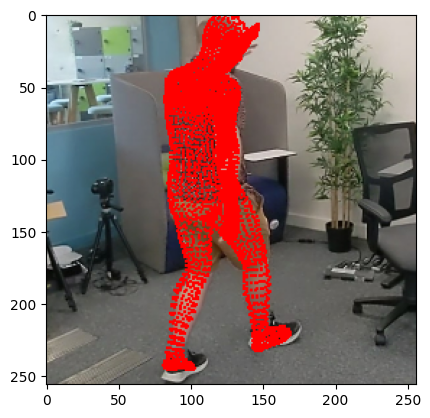

In [144]:
import trimesh
from matplotlib import pyplot as plt

# def render_smpl_on_image(cfg, vertices, faces, camera_translation, image):
focal_length = model_cfg.EXTRA.FOCAL_LENGTH
img_res = model_cfg.MODEL.IMAGE_SIZE

faces = model.smpl.faces
vertices = out['pred_vertices'][0].detach().cpu().numpy()

camera_center = [img_res // 2, img_res // 2]

image = batch['img'][0]
image = image.clone() * torch.tensor(model_cfg.MODEL.IMAGE_STD, device=image.device).reshape(3,1,1)
image = image + torch.tensor(model_cfg.MODEL.IMAGE_MEAN, device=image.device).reshape(3,1,1)
image = image.permute(1, 2, 0)

camera_translation = out['pred_cam_t'][0].detach().cpu().numpy()
camera_translation[0] *= -1.

mesh = trimesh.Trimesh(vertices.copy(), faces.copy())

rot = trimesh.transformations.rotation_matrix(
    np.radians(180), [1, 0, 0])

mesh.apply_transform(rot)

camera_pose = np.eye(4)
camera_pose[:3, 3] = camera_translation
camera_center = [image.shape[1] / 2., image.shape[0] / 2.]
fx = fy = model_cfg.EXTRA.FOCAL_LENGTH
cx = camera_center[0]
cy = camera_center[1]
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

camera_pose = camera_pose[:3, :4]

camera_pose = torch.tensor(camera_pose, dtype=torch.float32)
K = torch.tensor(K, dtype=torch.float32)
vertices = torch.tensor(mesh.vertices, dtype=torch.float32)

points_image = camera_projection(camera_pose, K, vertices)
image = plot_image_with_points(image, points_image, point_size=1)
plt.imshow(image)

In [103]:
img_cv2 = cv2.imread(img_path, cv2.COLOR_BGR2RGB) # not reading in the right colour space i need to actualy convert with cv2.COLOR_BGR2RGB
img_cv2.shape

(1072, 1906, 3)

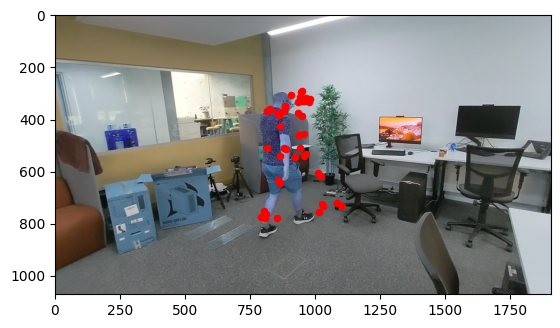

In [104]:
import matplotlib.pyplot as plt

# Extract the image from the batch and convert it to numpy format
img = batch['img'][0].permute(1,2,0).cpu().numpy()
pred_keypoints_2d = out['pred_keypoints_2d'][0].cpu().numpy()

# The image dimensions
h, w = img_cv2.shape[:2]

# Convert keypoints from (-1, 1) to image pixel coordinates
keypoints_2d = (pred_keypoints_2d + 1) / 2 * [w, h]

# Plot the image
plt.imshow(img_cv2)
plt.scatter(keypoints_2d[:, 0], keypoints_2d[:, 1], color='red', s=20)
plt.show()

In [66]:
smpl_params_dict = {
    'pose': np.array(smpl_pose),
    'betas': np.array(smpl_betas),
    'verts' : np.array(vertices),
    'joints3d' : np.array(key_points_3d),
    'joints2d' : np.array(key_points_2d)
}
# save as /workspace/data/smpl_splat/tom/4d_humans_smpl_params.pkl

import joblib

joblib.dump(smpl_params_dict, '/workspace/data/smpl_splat/tom/4d_humans_smpl_params.pkl')


['/workspace/data/smpl_splat/tom/4d_humans_smpl_params.pkl']

In [59]:
out['pred_smpl_params']['global_orient'] # [1, 1, 3, 3]
out['pred_smpl_params']['body_pose'] # [1, 23, 3, 3]
out['pred_smpl_params']['betas'][0].shape

torch.Size([10])

In [50]:
global_orient = matrix_to_axis_angle(out['pred_smpl_params']['global_orient'][0, 0])
body_pose_axis_angles = torch.stack([matrix_to_axis_angle(out['pred_smpl_params']['body_pose'][0, i]) for i in range(23)])
body_pose = body_pose_axis_angles.view(-1) # shape [69]
# preappend global_orient to body_pose
body_pose = torch.cat([global_orient, body_pose]) # shape [72]

torch.Size([72])

In [14]:
import joblib

smpl_params_path = '/workspace/data/neuman/dataset/tom_video/smpl_output_optimized.pkl'

smpl_params_optimised = joblib.load(smpl_params_path)

smpl_params_optimised[1]['pose'][0] # [72]
smpl_params_optimised[1]['betas'][0] # [10]

array([ 8.1405640e-03,  1.2069702e-02, -3.5266876e-03,  8.8729858e-03,
       -5.0659180e-03, -1.7957687e-03,  7.9333782e-05,  3.0498505e-03,
       -9.2411041e-04,  1.6317368e-03], dtype=float32)

In [ ]:
smpl_params_optimised

In [28]:
path = '/workspace/data/neuman/dataset/tom_video/smpl_pred/_home_user_neuman_data_neuman_dataset_tom_video_output_images_00000_png.npz'
data = np.load(path, allow_pickle=True)
print(data.files)
results = data['results']
results[0]['poses'] # [72]
results[0]['betas'] # [10]
results[0].keys()

['results']


dict_keys(['cam', 'poses', 'betas', 'j3d_all54', 'j3d_smpl24', 'j3d_spin24', 'j3d_op25', 'verts', 'pj2d', 'pj2d_org', 'trans', 'center_conf'])

In [73]:
results[0]['verts'].shape, results[0]['j3d_all54'].shape, results[0]['pj2d_org'].shape

((6890, 3), (54, 3), (54, 2))

In [80]:
results[0]['j3d_all54']

array([[-1.8129e-03, -2.2339e-01,  2.8137e-02],
       [ 2.0599e-02, -1.2299e-01, -2.3132e-02],
       [-2.3010e-02, -1.4343e-01,  1.0516e-01],
       [ 2.8809e-02, -3.3130e-01,  2.4261e-02],
       [-4.9744e-02,  2.4561e-01, -6.0120e-02],
       [-4.4556e-03,  2.1887e-01,  2.3352e-01],
       [ 2.2141e-02, -4.6362e-01, -4.4708e-03],
       [-6.2073e-02,  6.4209e-01, -1.3485e-03],
       [ 1.2549e-01,  5.8740e-01,  3.2495e-01],
       [-4.6654e-03, -5.1123e-01, -2.5635e-02],
       [-1.6345e-01,  7.0361e-01, -6.4636e-02],
       [ 1.2947e-02,  6.5869e-01,  3.4668e-01],
       [ 8.6975e-03, -7.2559e-01, -6.4453e-02],
       [ 4.2938e-02, -6.1914e-01, -1.1676e-01],
       [-1.4687e-02, -6.4941e-01,  3.0182e-02],
       [-4.0894e-02, -7.7783e-01, -1.0571e-01],
       [ 8.3984e-02, -6.0205e-01, -2.0227e-01],
       [-5.9875e-02, -6.8457e-01,  1.1432e-01],
       [ 1.7578e-01, -3.5913e-01, -2.3328e-01],
       [-1.8567e-01, -5.2246e-01,  2.6562e-01],
       [ 1.5198e-01, -1.1926e-01, -2.976

In [76]:
out['pred_vertices'].shape, out['pred_keypoints_3d'].shape, out['pred_keypoints_2d'].shape

(torch.Size([1, 6890, 3]), torch.Size([1, 44, 3]), torch.Size([1, 44, 2]))

In [77]:
out['pred_keypoints_2d']

tensor([[[ 0.0251, -0.3766],
         [-0.0718, -0.3494],
         [-0.0051, -0.2820],
         [-0.0177, -0.1411],
         [ 0.0024,  0.0078],
         [-0.1435, -0.3153],
         [-0.0962, -0.2835],
         [ 0.0043, -0.3854],
         [-0.0683, -0.0412],
         [-0.0315,  0.0125],
         [ 0.0733,  0.1546],
         [ 0.0789,  0.3676],
         [-0.0941,  0.0094],
         [-0.0941,  0.2018],
         [-0.1491,  0.4215],
         [ 0.0274, -0.4041],
         [ 0.0124, -0.4092],
         [-0.0119, -0.4185],
         [-0.0464, -0.4297],
         [-0.1039,  0.4503],
         [-0.1527,  0.4498],
         [-0.1710,  0.4423],
         [ 0.1385,  0.3451],
         [ 0.1585,  0.3682],
         [ 0.0641,  0.4070],
         [ 0.0780,  0.3521],
         [ 0.0606,  0.1268],
         [-0.0102, -0.0516],
         [-0.1440, -0.0505],
         [-0.0989,  0.1783],
         [-0.1568,  0.4001],
         [ 0.0111, -0.0061],
         [ 0.0043, -0.1493],
         [-0.0204, -0.3032],
         [-0.1

In [20]:
vibe_estimates['verts'].append(cur_res['verts'])
vibe_estimates['joints3d'].append(cur_res['j3d_all54'])
vibe_estimates['joints2d_img_coord'].append(cur_res['pj2d_org'])

NpzFile '/workspace/data/neuman/dataset/tom_video/smpl_pred/_home_user_neuman_data_neuman_dataset_tom_video_output_images_00000_png.npz' with keys: results